In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
from collections import defaultdict
from datetime import datetime as dt
from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('batterieDataPériode3.csv', low_memory = False)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df

,TIMESTAMP,Batt_Li_Voltage,Batt_Li_Current,Batt_Li_Power,Batt_Li_SoC,PV_Voltage,PV_Power,Batt_Li_SetPower_EMS
0,2022-07-20 00:00:00,26.59,0.000,0.00,82.70,1.005,0.00,-76.73
1,2022-07-20 00:00:01,26.59,0.000,0.00,82.70,1.005,0.00,-76.73
2,2022-07-20 00:00:02,26.59,0.000,0.00,82.70,1.005,0.00,-76.73
3,2022-07-20 00:00:03,26.59,0.000,0.00,82.70,1.005,0.00,-76.73
4,2022-07-20 00:00:04,26.59,0.000,0.00,82.70,1.005,0.00,-76.73
...,...,...,...,...,...,...,...,...
604794,2022-07-26 23:59:54,25.10,0.931,23.37,19.23,25.070,0.68,21.96
604795,2022-07-26 23:59:55,25.10,0.950,23.85,19.23,25.070,0.68,21.46
604796,2022-07-26 23:59:56,25.10,0.950,23.85,19.23,25.070,0.65,21.46
604797,2022-07-26 23:59:57,25.10,0.949,23.82,19.23,25.070,0.70,21.45


In [3]:
df['Batt_Li_Voltage'].describe()

count    604799.000000
mean         26.588118
std           0.598227
min          24.830000
25%          26.270000
50%          26.590000
75%          26.640000
max          28.560000
Name: Batt_Li_Voltage, dtype: float64

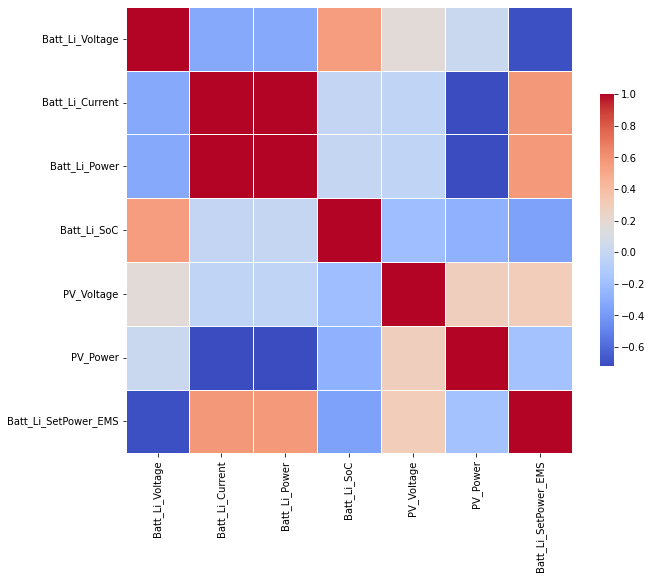

In [12]:
df_normalized = df.drop(['TIMESTAMP'],axis=1)
scaler = MinMaxScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized))
cols = df.columns[1:]
df_normalized.columns = cols

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df_normalized.corr(), cmap='coolwarm', fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.show()

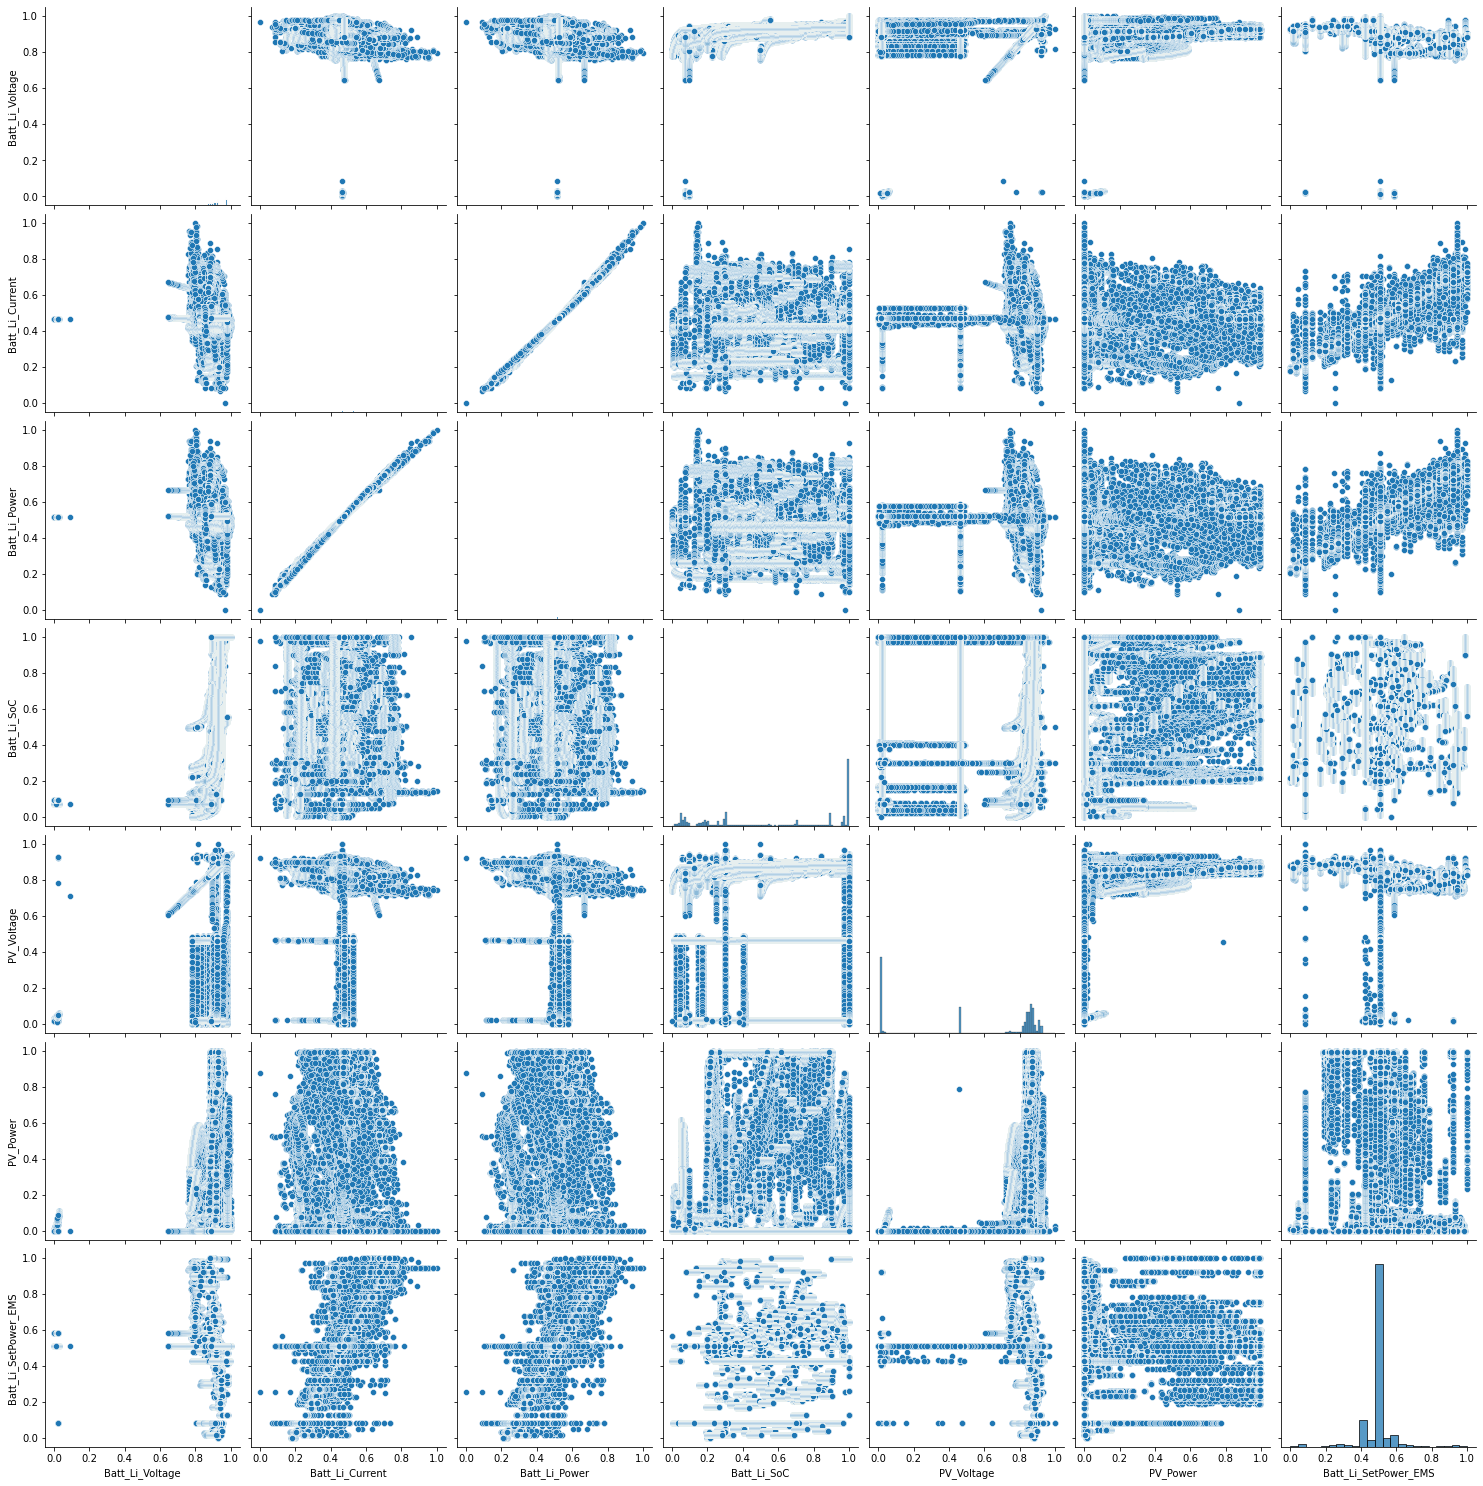

In [9]:
sns.pairplot(df_normalized, height=3)

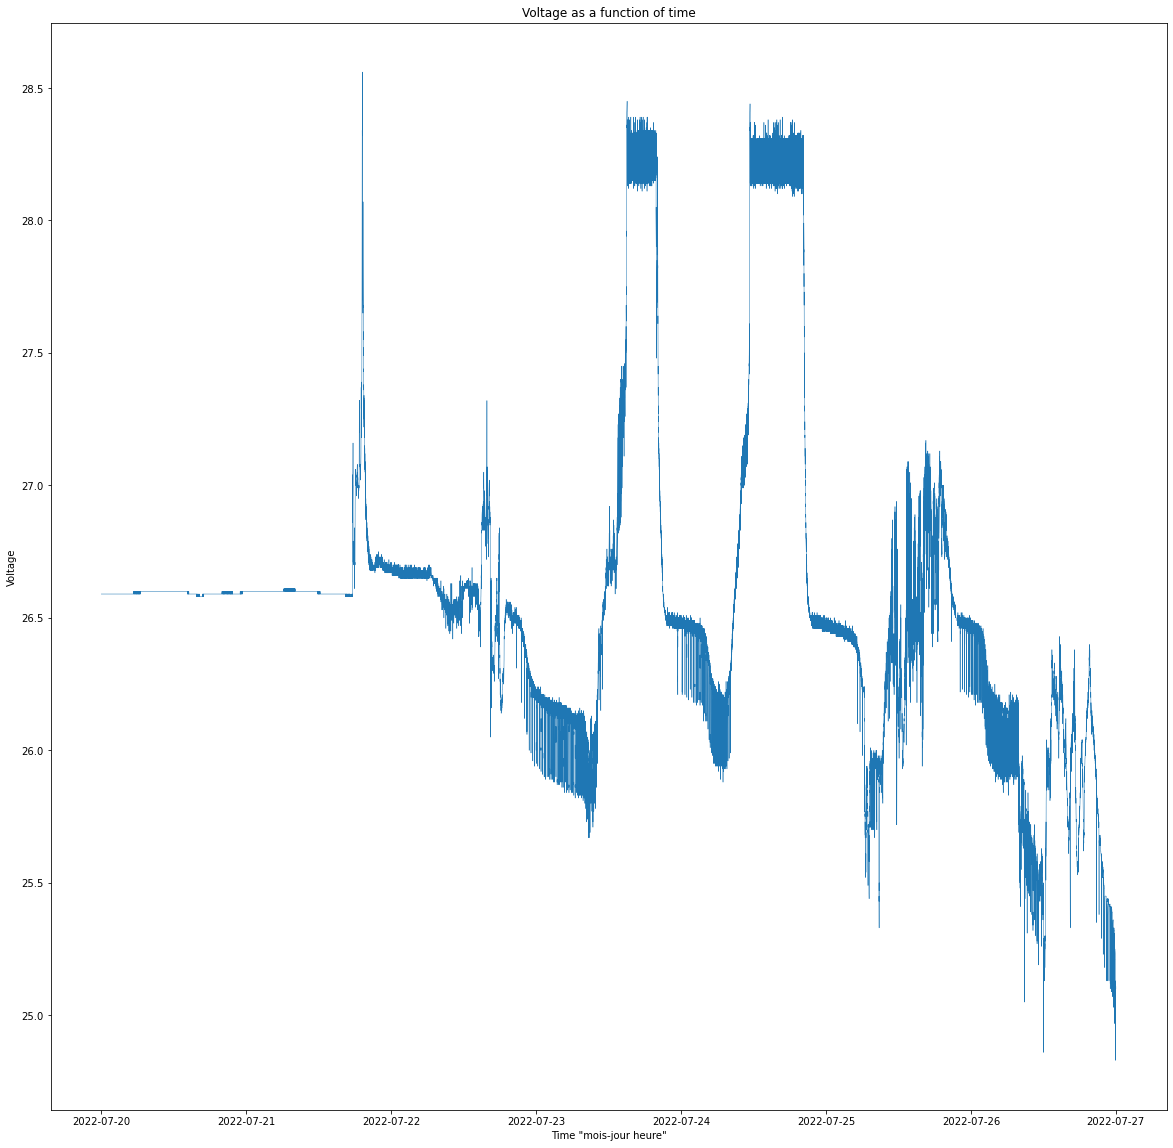

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.plot(df['TIMESTAMP'], df['Batt_Li_Voltage'],linewidth=0.5, markersize=0.05)

ax.set_title('Voltage as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Voltage')
fig.savefig('Voltage as a function of time during third period')

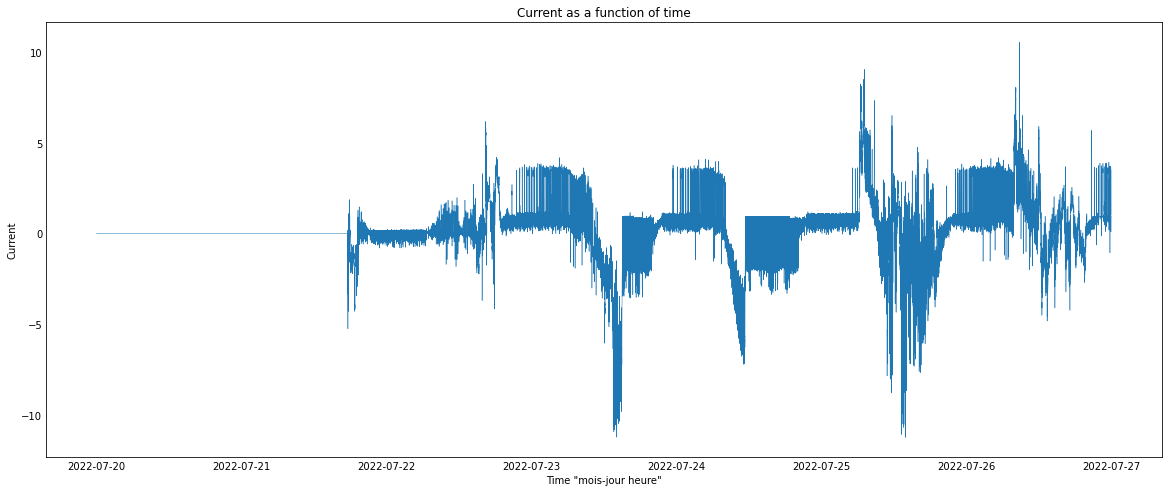

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_Current'],linewidth=0.5, markersize=0.05)

ax.set_title('Current as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Current')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('Current as a function of time during third period')

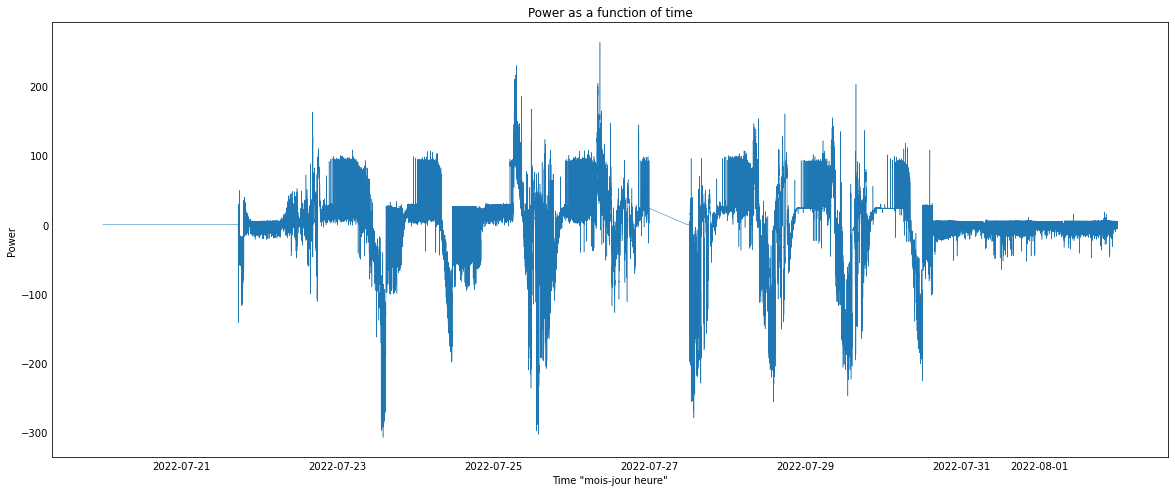

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_Power'],linewidth=0.5, markersize=0.05)

ax.set_title('Power as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Power')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('Power as a function of time during third period')

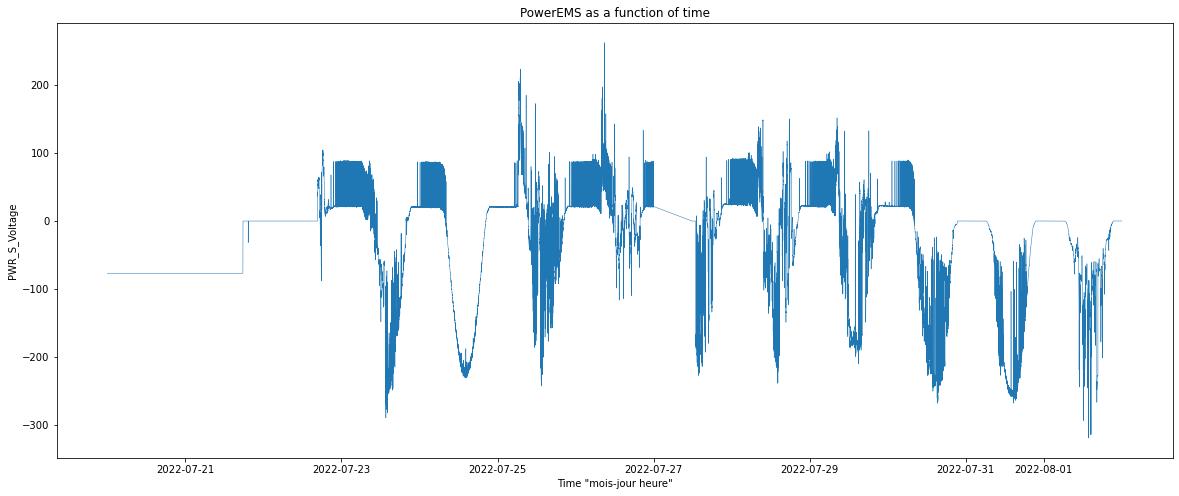

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_SetPower_EMS'], linewidth=0.5, markersize=0.05)

ax.set_title('PowerEMS as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('PWR_S_Voltage')
fig.savefig('Power EMS as a function of time during third period')

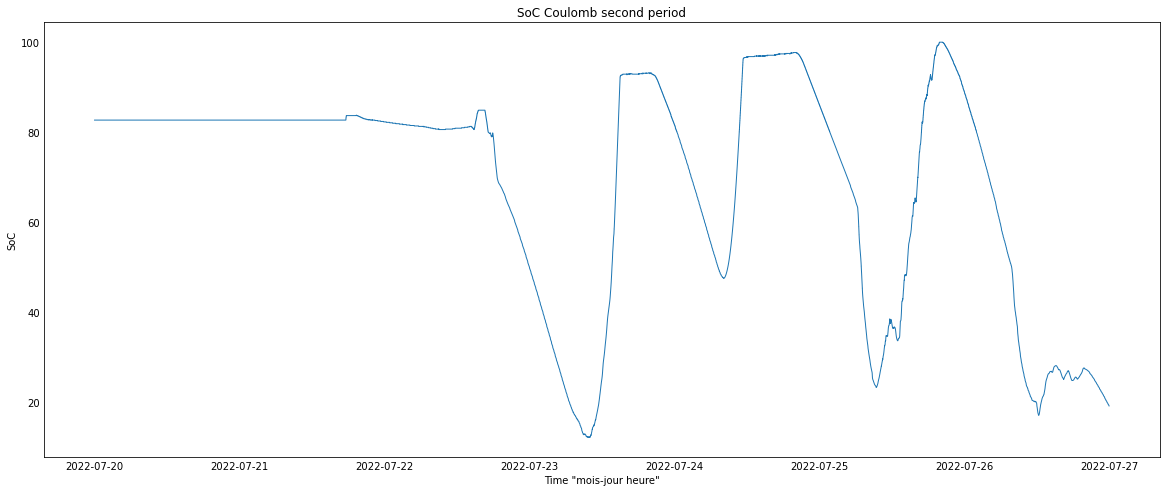

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_SoC'],linewidth=1, markersize=0.5)

ax.set_title('SoC Coulomb second period')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('SoC')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('SoC as a function of time during third period')

In [22]:
C_nom = 20
def state_of_charge(df):
    I = df['Batt_Li_Current']  # courant aux bornes de la batterie
    V = df['Batt_Li_Voltage']  # tension aux bornes de la batterie
    t = (df['TIMESTAMP'] - df['TIMESTAMP'].iloc[0]).dt.total_seconds()  # temps écoulé depuis le début des mesures en secondes
    Q = np.cumsum(I) * (t.diff().fillna(1))  # charge totale en Ah
    SOC = -(Q / C_nom)/100  # état de charge en pourcentage
    return SOC
df1 = df
df1['SoC_Tension'] = state_of_charge(df)
max_variation = 10
variations = df1['SoC_Tension'].diff()

lignes_a_supprimer = df1.loc[variations > max_variation].index
df1 = df1.drop(lignes_a_supprimer)

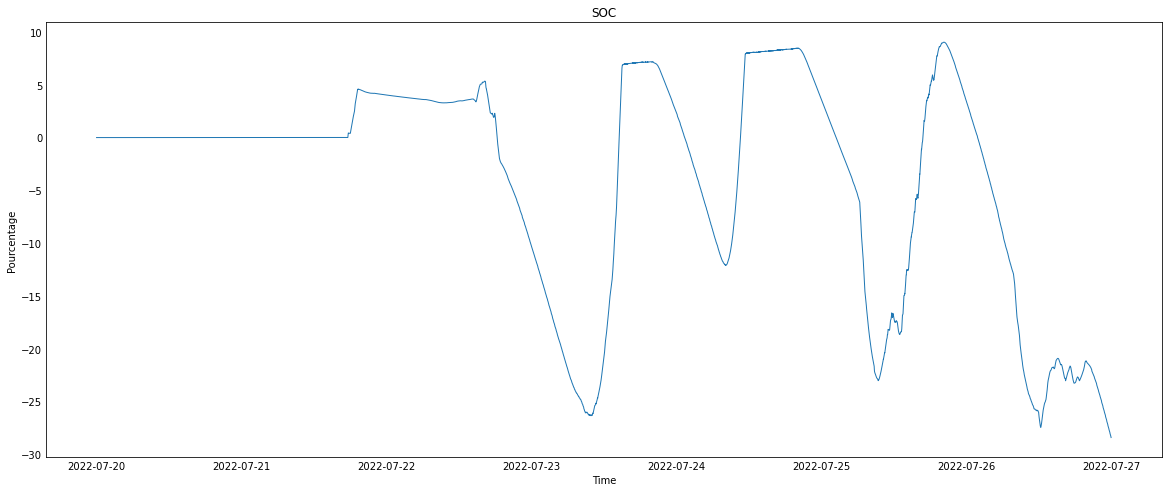

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df1['TIMESTAMP'], df1['SoC_Tension'], label='SOC',linewidth=1)

ax.set_title('SOC')
ax.set_xlabel('Time')
ax.set_ylabel('Pourcentage')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('SoC determined with tension as a function of SoC during third period')

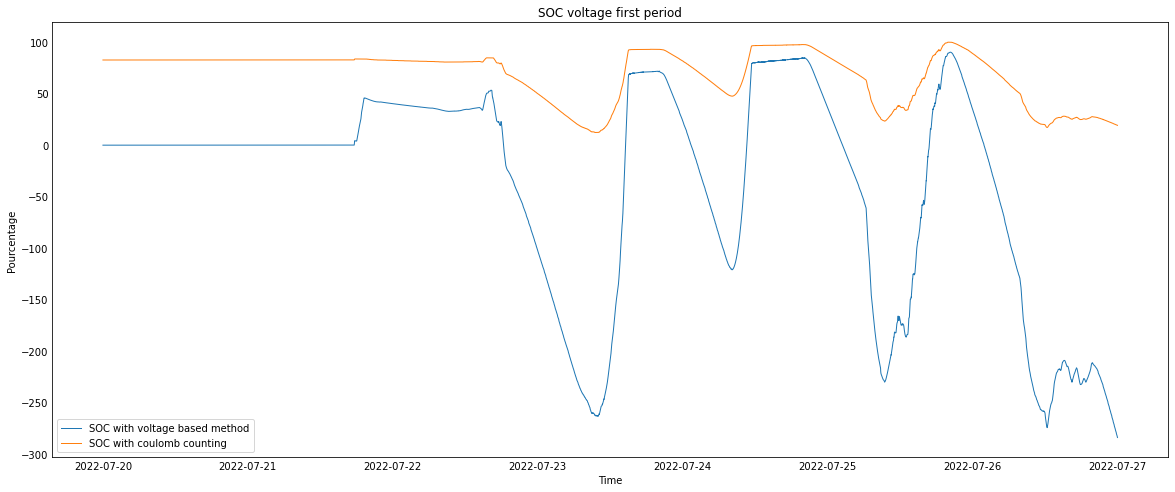

In [14]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df1['TIMESTAMP'], df1['SoC_Tension'], label='SOC with voltage based method',linewidth=1)
ax.plot(df['TIMESTAMP'], df['Batt_Li_SoC'],label='SOC with coulomb counting',linewidth=1, markersize=0.5)

ax.set_title('SOC voltage first period')
ax.set_xlabel('Time')
ax.set_ylabel('Pourcentage')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('SoC determined with tension as a function of SoC during first period')
plt.legend()